In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import time

## 目标：
1. 知道梯度法的收敛速度在图像中的表现形式，即$\log e_N$关于迭代次数$N$呈现线性负相关，其中$e_N$是第$N$次迭代时候的误差
2. 了解和对比精确直线搜索和回溯直线搜索的效果（从性能和所需要的时间角度出发）
3. 回溯直线搜索中参数的影响
4. 了解问题中不同方向的拉伸程度（即条件数）对于收敛速度的影响
5. 不同坐标系变换下的最速下降法的对比

### 建议的作业：
- 阅读代码并尝试修改优化问题、或者探索其他不同因素的影响

In [2]:
def exact_line_search(prob, x, d):
    """
        Exact line search along the direction d
    """
    phi = lambda t : prob.f(x + t * d)
    result = minimize_scalar(phi, bounds=(0, 10), method='bounded')
    return result.x

def backtracking_line_search(prob, x, d, alpha=0.1, beta=0.8):
    k = 0
    t = 1.0
    while prob.f(x + t * d) > prob.f(x) + t * alpha * np.dot(prob.df(x), d):
        t *= beta
        k += 1
    return t, k

In [3]:
class ProblemEg1:
    def __init__(self, γ=2.0, linesearch="exact", alpha=0.1, beta=0.8):
        self.γ = γ
        self.linesearch = linesearch
        self.alpha = alpha
        self.beta = beta
        self.tol = 1.0e-6
        self.ref_state = np.zeros(2) # 对该问题，我们有真解
        self.condition = "grad" # 停止条件
        self.P = np.eye(2) # 默认无坐标变换
        
    def f(self, x):
        """
            objective function f.
        """
        return (x[0]**2 + self.γ * x[1]**2)/2

    def df(self, x):
        """
            gradient of f
        """
        return np.array([x[0], self.γ*x[1]])
    
    def gradient_propose(self, x):
        return - np.matmul(self.P, self.df(x))
    
    def update(self, x):
        # 迭代更新一步
        d = self.gradient_propose(x)
        if self.linesearch == "exact":
            t = exact_line_search(self, x, d)
        elif self.linesearch == "backtracking":
            t, _ = backtracking_line_search(self, x, d, alpha=self.alpha, beta=self.beta)
        else:
            assert False, "use the correct one"
        return x + t * d
    
    def stop_condition(self,x):
        # 停止条件的判断
        if self.condition == "ref_state":
            return np.linalg.norm(x - self.ref_state) < self.tol
        elif self.condition == "grad":
            return np.linalg.norm(self.df(x)) < self.tol
        else:
            assert False, "use the correct one"

    def solve(self, x0, max_iter=100, num_repeat=1):
        t_begin = time.time()

        for k in range(num_repeat): # 需要num_repeat > 1仅为了稳定估计运行时间
            x = x0.copy()
            trajectory_exact = [x.copy()]
            for i in range(max_iter):
                x = self.update(x)
                trajectory_exact.append(x.copy())
                # 终止条件
                if self.stop_condition(x):
                    break

        runtime = (time.time() - t_begin)/num_repeat
        return np.array(trajectory_exact), runtime
    
    def plot_contour(self, xmin, xmax, ymin, ymax):
        grid_x = np.linspace(xmin, xmax, 400)
        grid_y = np.linspace(ymin, ymax, 300)
        grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
        Z = np.zeros((np.size(grid_X,0),np.size(grid_X,1)))
        
        for i in range(np.size(grid_X,0)):
            for j in range(np.size(grid_X,1)):
                Z[i,j] = self.f(np.array([grid_X[i,j], grid_Y[i,j]]))
        contour = plt.contourf(grid_X, grid_Y, Z, levels=20, cmap='Blues')
        plt.colorbar(contour)
        plt.xlabel(r'$x$', fontsize=12)
        plt.ylabel(r'$y$', fontsize=12)

## 探究迭代法收敛的表现形式

ELS uses 3.49E-03 seconds
BLS uses 2.79E-03 seconds


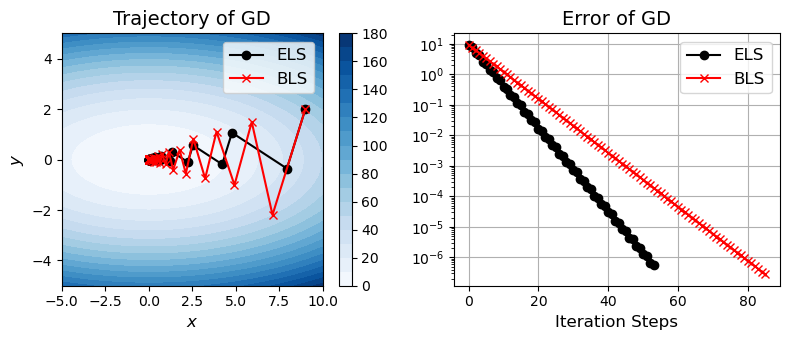

In [4]:
γ = 10.0
x0 = np.array([9.0, 2.0])
xmin = -5; xmax = γ; ymin = -5; ymax = 5
ls = "exact"
alpha = 0.1
beta = 0.8
prob = ProblemEg1(γ = γ, linesearch=ls, alpha = alpha, beta = beta)
num_repeat = 20 # 重复实验的次数，为了估计运行时间的结果的稳定

# 精确直线搜索
prob.linesearch = "exact"
trajectory_exact, runtime = prob.solve(x0, num_repeat=num_repeat)
print("ELS uses {:.2E} seconds".format(runtime))

# 回溯直线搜索
prob.linesearch = "backtracking"
trajectory_backtracking, runtime = prob.solve(x0, num_repeat=num_repeat)
print("BLS uses {:.2E} seconds".format(runtime))

# Plot the results
plt.figure(figsize=(8, 3.5))
plt.subplot(1, 2, 1)
plt.plot(trajectory_exact[:,0], trajectory_exact[:,1], 'ko-', label='ELS')
plt.plot(trajectory_backtracking[:, 0], trajectory_backtracking[:, 1], 'rx-', label='BLS')
prob.plot_contour(xmin, xmax, ymin, ymax)
plt.title("Trajectory of GD", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(np.linalg.norm(trajectory_exact, ord=2, axis=1), 'ko-', label='ELS')
plt.plot(np.linalg.norm(trajectory_backtracking, ord=2, axis=1), 'rx-', label='BLS')
plt.yscale('log')
plt.title("Error of GD", fontsize=14)
plt.xlabel("Iteration Steps",fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()

plt.show()

### 对于该问题，观察到的情况：

1. 对于相同的迭代步数，精确线性搜索大概率可以提高精度。
2. 但是从实际效果来看，达到同样的精度，精确线性搜索可能需要更多的计算时间。

这些结论只是经验结论，没有严格的保证

## 探究回溯直线搜索中参数的影响

In [5]:
def effect_of_alpha_and_beta(alpha, beta, x0, max_iter):
    ls = "backtracking"
    prob = ProblemEg1(γ = γ, linesearch=ls, alpha = alpha, beta = beta)
    prob.condition = "ref_state"
    prob.tol = 1.0e-5
    traj, runtime = prob.solve(x0, max_iter=max_iter)
    iter_step = np.size(traj,0)-1
    final_state = traj[-1,:]
    err = np.linalg.norm(final_state)  # 如此计算是因为此处的真解是[0,0]
    return err, iter_step, runtime

In [6]:
def visualize_effect_alpha_beta(beta_list, max_iter=200):
    x0 = [5.0, 6.0] # 本次实验固定的初始值
    alpha_list = np.linspace(0.01, 0.96, 20)

    for i in range(len(beta_list)):
        beta = beta_list[i]
        err_list = np.zeros(len(alpha_list))
        iter_list = np.zeros(len(alpha_list))
        runtime_list = np.zeros(len(alpha_list))

        for j in range(len(alpha_list)):
            err_list[j], iter_list[j], runtime_list[j] = \
                effect_of_alpha_and_beta(alpha_list[j], beta, x0, max_iter)

        plt.subplot(1, 3, 1)
        plt.plot(alpha_list, err_list, 'o-.', label=r"$beta={:.2f}$".format(beta))
        plt.ylim([10**-6, 10**-3])
        plt.yscale("log")
        if i == len(beta_list)-1:
            plt.xlabel(r"$\alpha$",fontsize=14)
            plt.title('Error', fontsize=16)

        plt.subplot(1, 3, 2)
        plt.plot(alpha_list, iter_list, 'o-.', label=r"$beta={:.2f}$".format(beta))
        plt.ylim([0, max_iter])
        if i == len(beta_list)-1:
            plt.xlabel(r"$\alpha$",fontsize=14)
            plt.title('Iteration Steps',fontsize=16)

        plt.subplot(1, 3, 3)
        plt.plot(alpha_list, runtime_list * 10**3, 'o-.', label=r"$beta={:.2f}$".format(beta))
        plt.ylim([0, 10])
        if i == len(beta_list)-1:
            plt.xlabel(r"$\alpha$",fontsize=14)
            plt.title('Runtime (ms)', fontsize=16)
            plt.legend(fontsize=12)

    plt.tight_layout()

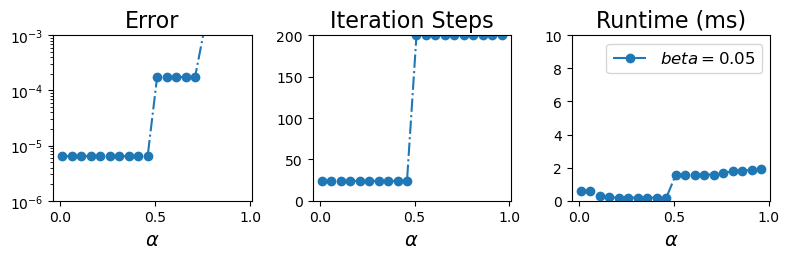

In [7]:
beta_list = [0.05]
plt.figure(figsize=(8,2.7))
visualize_effect_alpha_beta(beta_list)

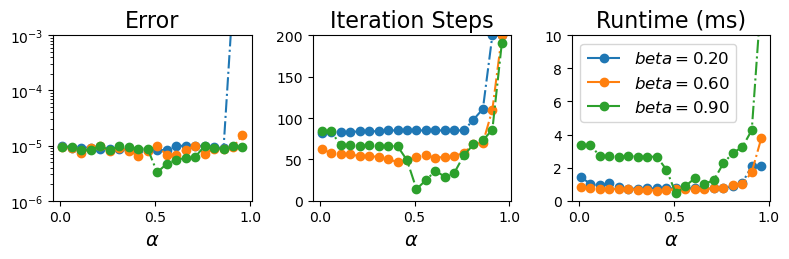

In [8]:
beta_list = [0.2, 0.6, 0.9]
plt.figure(figsize=(8,2.7))
visualize_effect_alpha_beta(beta_list)

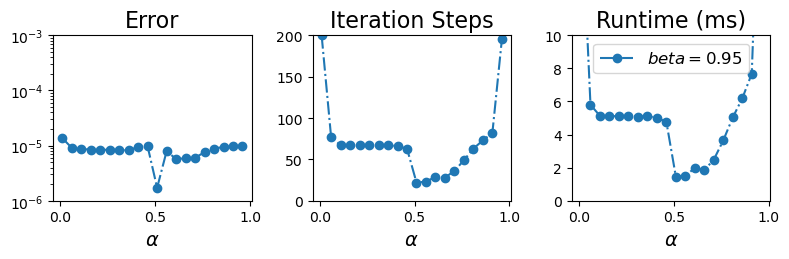

In [9]:
beta_list = [0.95]
plt.figure(figsize=(8,2.7))
visualize_effect_alpha_beta(beta_list)

## 探究问题本身对于迭代次数的影响，即系数$\gamma$

In [10]:
def effect_of_gamma(γ, x0):
    ls = "exact"
    max_iter = 200
    alpha = 0.1
    beta = 0.8
    prob = ProblemEg1(γ = γ, linesearch=ls, alpha = alpha, beta = beta)
    num_repeat = 10 # 重复实验的次数，为了估计运行时间结果更稳定

    prob.linesearch = "exact"
    trajectory_exact, runtime = prob.solve(x0, max_iter=max_iter, num_repeat=num_repeat)
    print("ELS uses {:.2E} seconds".format(runtime))

    prob.linesearch = "backtracking"
    trajectory_backtracking, runtime = prob.solve(x0, max_iter=max_iter, num_repeat=num_repeat)
    print("BLS uses {:.2E} seconds".format(runtime))

    # Plot the results
    plt.plot(np.linalg.norm(trajectory_exact, ord=2, axis=1), 'o-', 
             label='ELS, γ = {:.2f}'.format(γ))
    plt.plot(np.linalg.norm(trajectory_backtracking, ord=2, axis=1), 'x-', 
             label='BLS, γ = {:.2f}'.format(γ))
    
    plt.yscale('log')
    plt.title("Error of GD", fontsize=14)
    plt.xlabel('Iteration Steps',fontsize=12)
    plt.legend(bbox_to_anchor=(1, 0.85),fontsize=12)
    plt.grid()

ELS uses 4.68E-03 seconds
BLS uses 1.29E-03 seconds

ELS uses 2.28E-03 seconds
BLS uses 6.50E-04 seconds

ELS uses 1.18E-03 seconds
BLS uses 3.24E-04 seconds



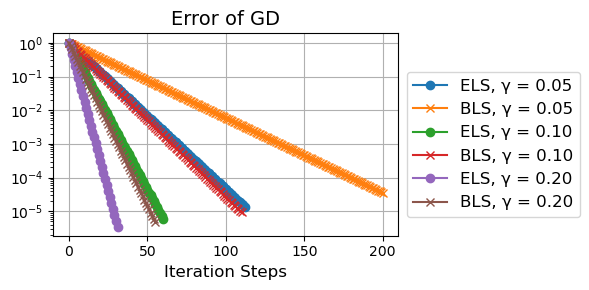

In [11]:
plt.figure(figsize=(6,3))
effect_of_gamma(0.05, np.array([0.05, 1])); print()
effect_of_gamma(0.10, np.array([0.10, 1])); print()
effect_of_gamma(0.20, np.array([0.20, 1])); print()
plt.tight_layout()
plt.show()

ELS uses 1.86E-03 seconds
BLS uses 8.01E-04 seconds

ELS uses 4.06E-03 seconds
BLS uses 1.87E-03 seconds

ELS uses 1.00E-02 seconds
BLS uses 4.80E-03 seconds



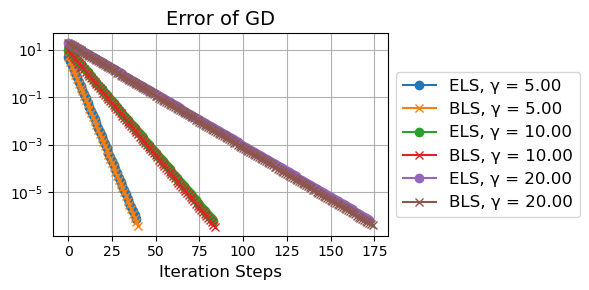

In [12]:
plt.figure(figsize=(6,3))
effect_of_gamma(5.00, np.array([5.00, 1])); print()
effect_of_gamma(10.00, np.array([10.00, 1])); print()
effect_of_gamma(20.00, np.array([20.00, 1])); print()
plt.tight_layout()
plt.show()

## 初值对于问题的解影响也很大

ELS uses 2.65E-03 seconds
BLS uses 1.30E-03 seconds

ELS uses 3.18E-04 seconds
BLS uses 6.98E-04 seconds

ELS uses 3.46E-04 seconds
BLS uses 3.60E-04 seconds



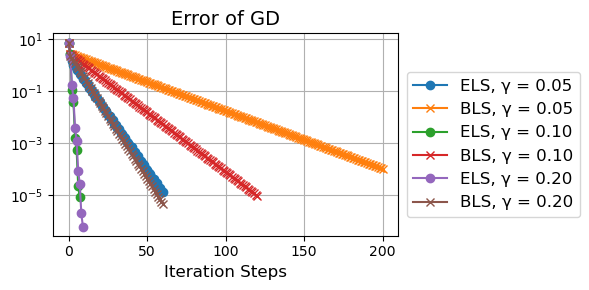

In [13]:
x0 = np.array([7.0, 3.0]) # Initial guess

plt.figure(figsize=(6,3))
effect_of_gamma(0.05, x0.copy()); print()
effect_of_gamma(0.10, x0.copy()); print()
effect_of_gamma(0.20, x0.copy()); print()
plt.tight_layout()
plt.show()

ELS uses 1.39E-03 seconds
BLS uses 7.62E-04 seconds

ELS uses 1.34E-03 seconds
BLS uses 1.82E-03 seconds

ELS uses 1.09E-03 seconds
BLS uses 4.68E-03 seconds



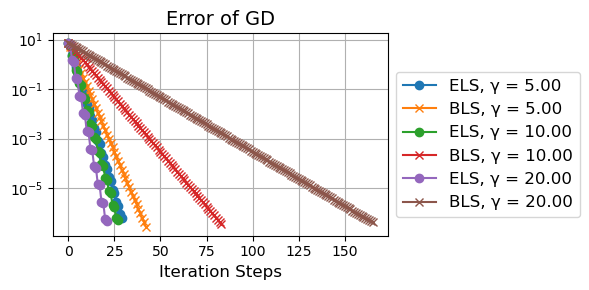

In [14]:
plt.figure(figsize=(6,3))
effect_of_gamma(5.0, x0.copy()); print()
effect_of_gamma(10.0, x0.copy()); print()
effect_of_gamma(20.0, x0.copy()); print()
plt.tight_layout()
plt.show()

## 不同坐标系的影响

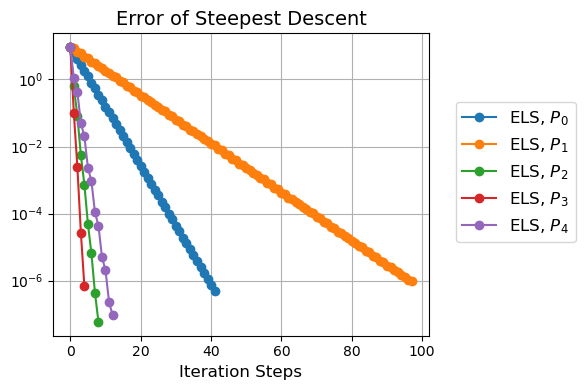

In [15]:
γ = 5.0
x0 = np.array([9.0, 2.0])
 
Plist = [np.eye(2), np.array([[1,0],[0,4]]), np.array([[1,0],[0,1/4]]), \
         np.array([[1,0],[0,1/4.8]]), np.array([[1,0],[0,1/10]])]

plt.figure(figsize=(6,4))
for P_idx in range(len(Plist)):
    P = Plist[P_idx]
    
    ls = "exact"
    alpha = 0.1
    beta = 0.8
    prob = ProblemEg1(γ = γ, linesearch=ls, alpha = alpha, beta = beta)
    prob.P = P
    trajectory_exact, runtime = prob.solve(x0)

    plt.plot(np.linalg.norm(trajectory_exact, ord=2, axis=1), 'o-',
             label=r'ELS, $P_{:d}$'.format(P_idx))

plt.yscale('log')
plt.title("Error of Steepest Descent", fontsize=14)
plt.xlabel("Iteration Steps",fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1.05,0.8))
plt.grid()
plt.tight_layout()
plt.show()

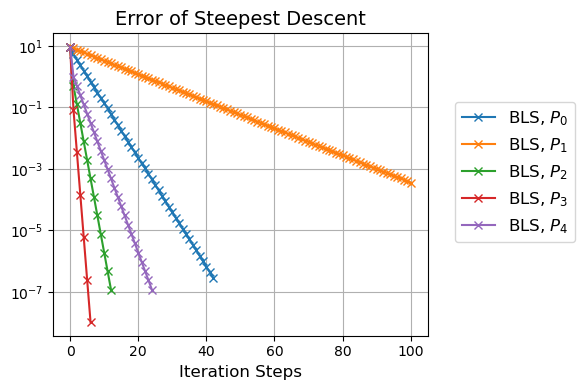

In [16]:
plt.figure(figsize=(6,4))
for P_idx in range(len(Plist)):
    P = Plist[P_idx]
    ls = "backtracking"
    alpha = 0.1
    beta = 0.8
    prob = ProblemEg1(γ = γ, linesearch=ls, alpha = alpha, beta = beta)
    prob.P = P
    trajectory_backtracking, runtime = prob.solve(x0)
    
    plt.plot(np.linalg.norm(trajectory_backtracking, ord=2, axis=1), 'x-', 
             label=r'BLS, $P_{:d}$'.format(P_idx))

plt.yscale('log')
plt.title("Error of Steepest Descent", fontsize=14)
plt.xlabel("Iteration Steps",fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1.05,0.8))
plt.grid()
plt.tight_layout()
plt.show()